<a href="https://colab.research.google.com/github/tcmb1987/EE274-lossy-text-compression/blob/main/milestone_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install required packages.

In [ ]:
!pip install sent2vec
!pip install zstd

Import libraries and data. Using excerpt of book of Genesis from Gutenburg website for data. The imported text is striped down into a list of sentences with non-English words and symbols removed.

Finally, using the NLTK functions to remove stopwords, a pruned version of the text list is created.

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import string
from urllib import request
from bs4 import BeautifulSoup
from sent2vec.vectorizer import Vectorizer
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')

urls = ["https://www.gutenberg.org/cache/epub/10/pg10.txt"] 
sentences = []
words = set(nltk.corpus.words.words())

for url in urls:
    response = request.urlopen(url)
    soup = BeautifulSoup(response, features="html.parser")
    text = soup.get_text()
    sentences += sent_tokenize(text)

# Strip random symbols/non-English
sentences = list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sentences))
sentences = [sentence.replace("\r", "") for sentence in sentences]
sentences = [sentence.replace("\n", " ") for sentence in sentences]
sentences = [sentence.replace(":", "") for sentence in sentences]
# sentences = [re.sub(r'[^\w\s]', '', sentence) for sentence in sentences]
sentences = ["".join(i for i in s if not i.isdigit()) for s in sentences]
sentences = sentences[4:]
sentences = [s for s in sentences if not len(s) > 512]

stop_words = set(stopwords.words('english'))
  
def prune_sentence(sentence, stop_words):
    word_tokens = word_tokenize(sentence)
    return ' '.join([w for w in word_tokens if not w.lower() in stop_words and not w.lower() in string.punctuation]) 

pruned_sentences = [prune_sentence(sentence, stop_words) for sentence in sentences]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Calculated the size of the original text and pruned text uncompressed, using gzip, and using zstd at the highest compression level.

In [44]:
import sys
import gzip
import zstd

original_text = ' '.join(sentences)
pruned_text = ' '.join(pruned_sentences)
original_size = (sys.getsizeof(original_text) / 1024)
pruned_size = (sys.getsizeof(pruned_text) / 1024)

print("Uncompressed size of original text is %.2f KB." % original_size)
print("Uncompressed size of pruned text is %.2f KB." % pruned_size)
print("Pruned text is %.1f%% size of original text.\n" % (pruned_size/original_size*100))

original_compressed = gzip.compress(bytes(original_text, 'utf-8'))
pruned_compressed = gzip.compress(bytes(pruned_text, 'utf-8'))
original_size = (sys.getsizeof(original_compressed) / 1024)
pruned_size = (sys.getsizeof(pruned_compressed) / 1024)

print("Compressed size of original text using gzip is %.2f KB." % original_size)
print("Compressed size of pruned text using gzip is %.2f KB." % pruned_size)
print("Pruned text compresses to %.1f%% size of compressed original text.\n" % (pruned_size/original_size*100))

original_compressed = zstd.compress(bytes(original_text, 'utf-8'), 22)
pruned_compressed = zstd.compress(bytes(pruned_text, 'utf-8'), 22)
original_size = (sys.getsizeof(original_compressed) / 1024)
pruned_size = (sys.getsizeof(pruned_compressed) / 1024)

print("Compressed size of original text using zstd level 22 is %.2f KB." % original_size)
print("Compressed size of pruned text using zstd level 22 is %.2f KB." % pruned_size)
print("Pruned text compresses to %.1f%% size of compressed original text." % (pruned_size/original_size*100))

Uncompressed size of original text is 7742.31 KB.
Uncompressed size of pruned text is 4440.13 KB.
Pruned text is 57.3% size of original text.

Compressed size of original text using gzip is 1126.90 KB.
Compressed size of pruned text using gzip is 678.99 KB.
Pruned text compresses to 60.3% size of compressed original text.

Compressed size of original text using zstd level 22 is 853.40 KB.
Compressed size of pruned text using zstd level 22 is 541.40 KB.
Pruned text compresses to 63.4% size of compressed original text.


Use BERT method and sent2vec to create embeddings for the original sentence list.

In [47]:
original_vectorizer = Vectorizer()
original_vectorizer.run(sentences[0:1000])
original_sentence_vectors = original_vectorizer.vectors

Initializing Bert distilbert-base-uncased
Vectorization done on cpu


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use BERT method and sent2vec to create embeddings for the pruned sentence list.

In [ ]:
pruned_vectorizer = Vectorizer()
pruned_vectorizer.run(pruned_sentences[0:1000])
pruned_sentence_vectors = pruned_vectorizer.vectors

Initializing Bert distilbert-base-uncased
Vectorization done on cpu


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Import libraries and intialize variables for conducting reconstruction via a trained ML model. Train data is 80% of the text, and then tested on the remainder.

In [ ]:
# Reconstruction time...

import torch
import torch.nn as nn
import numpy as np

data_x = torch.as_tensor(pruned_sentence_vectors)
data_y = torch.as_tensor(original_sentence_vectors)

train_size = int(np.floor(len(data_x) * 0.8))
test_size = len(data_x) - train_size

train_x = data_x[0:train_size]
train_y = data_y[0:train_size]

test_x = data_x[train_size:]
test_y = data_y[train_size:]

In [ ]:
n_input, n_hidden, n_out, batch_size, learning_rate = len(original_sentence_vectors[0]), len(original_sentence_vectors[0]), len(pruned_sentence_vectors[0]), train_size, 0.01
model = nn.Sequential(nn.Linear(n_input, n_hidden, bias=False),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out, bias=False))
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
losses = []
for epoch in range(2000):
    pred_y = model(train_x)
    loss = loss_function(pred_y, train_y)
    losses.append(loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

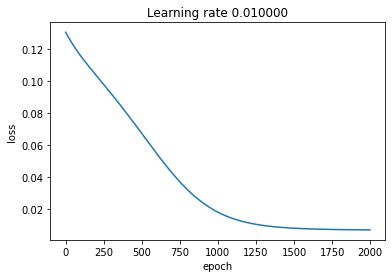

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

# Conclusion: 2000 epochs are more than enough.

In [ ]:
pred_y = model(test_x)

In [ ]:
pred_y = pred_y.detach().numpy()

In [ ]:
test_y = test_y.detach().numpy() 

In [ ]:
len(pred_y)

200

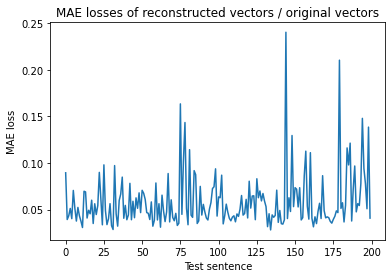

In [ ]:
# Various loss functions on pred and test

mae_loss = nn.L1Loss()
mae_losses = [mae_loss(torch.Tensor(pred_y[i]), torch.Tensor(test_y[i])) for i in range(len(test_y))]

plt.plot(mae_losses)
plt.ylabel('MAE loss')
plt.xlabel('Test sentence')
plt.title("MAE losses of reconstructed vectors / original vectors")
plt.show()

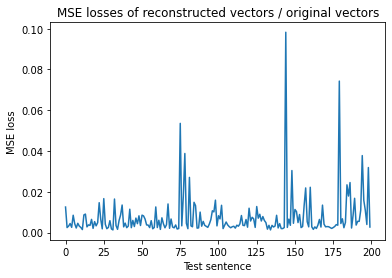

In [ ]:
mse_loss = nn.MSELoss()
mse_losses = [mse_loss(torch.Tensor(pred_y[i]), torch.Tensor(test_y[i])) for i in range(len(test_y))]

plt.plot(mse_losses)
plt.ylabel('MSE loss')
plt.xlabel('Test sentence')
plt.title("MSE losses of reconstructed vectors / original vectors")
plt.show()

In [ ]:
from scipy.spatial import distance

# Distances between pruned and original vectors

distances = []

for i in range(len(data_x)):
  dist = distance.cosine(original_sentence_vectors[i], pruned_sentence_vectors[i])
  distances.append(dist)

# Distances between reconstructed and original vectors

cosine_errors = []

for i in range(len(test_x)):
  dist = distance.cosine(test_y[i], pred_y[i])
  cosine_errors.append(dist)

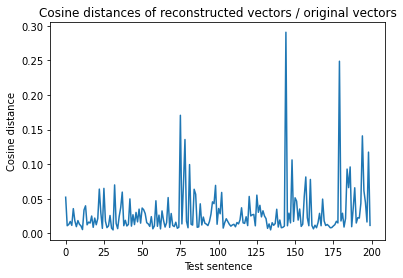

In [ ]:
plt.plot(cosine_errors)
plt.ylabel('Cosine distance')
plt.xlabel('Test sentence')
plt.title("Cosine distances of reconstructed vectors / original vectors")
plt.show()

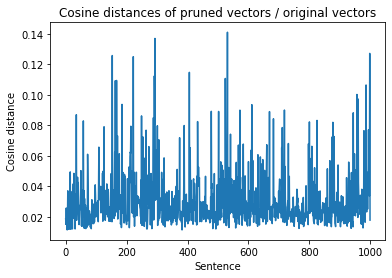

In [ ]:
plt.plot(distances)
plt.ylabel('Cosine distance')
plt.xlabel('Sentence')
plt.title("Cosine distances of pruned vectors / original vectors")
plt.show()

In [ ]:
# Pretty low! Wonderfully low!!
np.mean(cosine_errors)

0.02950080931186676

In [ ]:
np.mean(distances)

0.03042340940237045